<a href="https://colab.research.google.com/github/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/Tutorial_for_Neural_Network_Verification_with_Marabou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial for Neural Network Verification with Marabou

---

*As an example we try to verifiy the **robustness** of a classification Network trained on the MNIST dataset using [Marabou](https://neuralnetworkverification.github.io/).*

Important Links:
- [Marabou sourcecode](https://github.com/NeuralNetworkVerification/Marabou)
- [Marabou documenation](https://neuralnetworkverification.github.io/Marabou/)

---

## Prerequisites

In [121]:
import torch
from torch import nn
import numpy as np

import torch.onnx

In [122]:
%%capture

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/mnist_trainer.py'}

In [127]:
import mnist_trainer

First, we will train a neural network with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset

In [128]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, number_of_neurons):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [129]:
%%capture
train_dataloader, test_dataloader = mnist_trainer.load_mnist_dataset(batch_size=64)

In [8]:
model_filename = "mnist_net.onnx"

## Train and export Neural Network

In [9]:
model = mnist_trainer.train_model(
    NeuralNetwork(input_dim=28*28, output_dim=10, number_of_neurons=20), 
    epochs=3, 
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    )

Epoch 1
-------------------------------


100%|██████████| 938/938 [00:06<00:00, 150.17it/s]


Test Error: 
 Accuracy: 91.3%, Avg loss: 0.296179 

Epoch 2
-------------------------------


100%|██████████| 938/938 [00:06<00:00, 154.39it/s]


Test Error: 
 Accuracy: 93.1%, Avg loss: 0.230674 

Epoch 3
-------------------------------


100%|██████████| 938/938 [00:06<00:00, 152.31it/s]


Test Error: 
 Accuracy: 94.2%, Avg loss: 0.200142 

Done!


In [10]:
# set model to eval mode
model.eval()

# create a dummy input in the shape of the input values
device = "cuda" if torch.cuda.is_available() else "cpu"
dummy_input = torch.randn(1, 28, 28).to(device)

torch.onnx.export(model,
                  dummy_input,
                  model_filename,
                  export_params=True,
                  verbose=False,
                  input_names=['image'],
                  output_names=['classification'],
                  )

## Install Marabou

In [11]:
!git clone https://github.com/NeuralNetworkVerification/Marabou.git
!cd Marabou && git checkout "492c1b8c703c8a383f421468a104c34710e6d26d"

Cloning into 'Marabou'...
remote: Enumerating objects: 25703, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 25703 (delta 7), reused 5 (delta 0), pack-reused 25686
Receiving objects: 100% (25703/25703), 208.53 MiB | 21.93 MiB/s, done.
Resolving deltas: 100% (18530/18530), done.
Note: checking out '492c1b8c703c8a383f421468a104c34710e6d26d'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 492c1b8c Remove ConstraintBoundTightener (#560)


The following script builds and installs marabou. It works in Google Colab (%%shell is colab specific) and takes about 15 minutes there.

In [12]:
%%shell
cd Marabou
mkdir build
cd build
cmake .. -DBUILD_PYTHON=ON
cmake --build .
cd /content

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
                   LWORK_DORMBR=DUM(1)
                               1
dgelss.f:355:31:

                   LWORK_DORGBR=DUM(1)
                               1
dgelss.f:444:0:

          IF( M.GE.MNTHR ) THEN
 
dgeqlf.f:158:0:

      $                   MU, NB, NBMIN, NU, NX
 
dgerqf.f:158:0:

      $                   MU, NB, NBMIN, NU, NX
 
dgesvd.f:3472:0:

          IF( IE.LT.2 ) THEN
 
dgesvd.f:240:0:

      $                   NRVT, WRKBL
 
dgesvd.f:677:0:

          IF( M.GE.MNTHR ) THEN
 
dgesvd.f:237:0:

       INTEGER            BDSPAC, BLK, CHUNK, I, IE, IERR, IR, ISCL,
 
dgesvdx.f:670:0:

          IF( N.GE.MNTHR ) THEN
 
dgesvx.f:441:0:

                ROWCND = MAX( RCMIN, SMLNUM ) / MIN( RCMAX, BIGNUM )
 
dgesvx.f:441:0: Warning: ‘bignum’ may be used uninitialized in this function [-Wmaybe-uninitialized]
dgetc2.f:222:0:

          A( N, N ) = SMIN
 
dgetc2.f:204:0:

      $      CALL DSWAP( N, A( 1, JPV

In [14]:
%pip install onnx onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load Marabou

add marabou to pythonpath

In [15]:
import sys
sys.path.insert(1, '/content/Marabou')

import marabou

In [16]:
from maraboupy import Marabou

Instructions for updating:
non-resource variables are not supported in the long term


In [17]:
options = Marabou.createOptions(verbosity = 0)

## Verify Robustness

load network in onnx format in marabou and get input and output marabou variables from network

In [87]:
network = Marabou.read_onnx(model_filename)
inputVars = network.inputVars[0][0]
outputVars = network.outputVars[0][0]

choose a fixed input image

In [110]:
inputs, classes = next(iter(train_dataloader))
image = inputs[0].numpy()[0]
correct_class = classes[0].item()

predict with network

In [111]:
network_ouput = network.evaluateWithoutMarabou([image])[0]
predicted_class = np.argmax(network_ouput)

plot the image

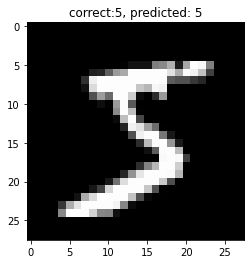

In [112]:
import matplotlib.pyplot as plt
plt.title(f"correct:{correct_class}, predicted: {predicted_class}")
plt.imshow(image.reshape(28,28), cmap='gray')

robustness

choose epsilon

In [113]:
epsilon = 0.1

add input constraints

In [114]:
for h in range(inputVars.shape[0]):
  for w in range(inputVars.shape[1]):
    network.setLowerBound(inputVars[h][w], image[h][w] - epsilon)
    network.setUpperBound(inputVars[h][w], image[h][w] + epsilon)

add output constraints and solve

In [115]:
for i in range(outputVars.shape[0]):
  if i != correct_class:
    # add max constraint
    network.addMaxConstraint(set(outputVars), outputVars[i])
    # solve
    exit_code, vals, stats = network.solve(verbose = False, options = options)
    # if solution found, break
    print(exit_code)
    if len(vals) > 0:
      break

sat


get image from marabou vals output

In [116]:
adversarial_image = [[] for _ in range(inputVars.shape[1])]
for h in range(inputVars.shape[0]):
  for w in range(inputVars.shape[1]):
    adversarial_image[h].insert(w, vals[inputVars[h][w]])
adversarial_image = np.array(adversarial_image)

get output from marabou

In [117]:
outputs = []
for h in range(outputVars.shape[0]):
  outputs.insert(h, vals[outputVars[h]])
print(outputs)
print(np.argmax(outputs))

[1.4159239348306913, -3.889280593357533, -2.7551021285732964, -0.2232630334114276, -5.660504637877538, 1.4159239348306913, -4.353872194012604, 1.4159239348306913, -4.288238764644706, 0.415966542517953]
0


show adversarial example

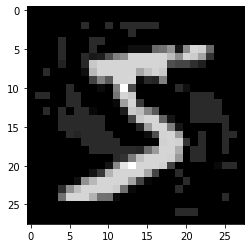

In [118]:
plt.imshow(adversarial_image, cmap='gray')

predict adversarial example with network

In [119]:
network_ouput = network.evaluateWithoutMarabou([adversarial_image])[0]
predicted_class = np.argmax(network_ouput)
print(predicted_class)

5


Alternative: use included function (not mentioned in documentation) to verify robustness with epsilon=0.05 (first need to reload the network)

In [120]:
epsilon = 0.05

network = Marabou.read_onnx(model_filename)
network.evaluateLocalRobustness(image, epsilon, correct_class, options=options)

unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat


[{}, <maraboupy.MarabouCore.Statistics at 0x7f6bfce8b830>, None]